# Data Prep
This notebook summarizes the steps that went into processing the raw data into the train and test data that was used for the competition.

In [1]:
import os 
import numpy as np
import json
import tifffile as tiff
import random
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

## Examining the Raw Data

### Different Data Files

We have 3 different folders coontaining different data:
* *raw_tiffs*
* *label_json*
* *meta*

In [2]:
rawtiffs_path = '/workspace/Competition/map_segmentation/data/RAW/train/raw_tiffs'
labeljsons_path = '/workspace/Competition/map_segmentation/data/RAW/train/label_json'
metafiles_path = '/workspace/Competition/map_segmentation/data/RAW/train/meta'

raw_tiffs = os.listdir(rawtiffs_path)
label_jsons = os.listdir(labeljsons_path)
meta_files = os.listdir(metafiles_path)

In [3]:
len(raw_tiffs), len(label_jsons), len(meta_files)

(13520, 13520, 13520)

We have 13,520 files of each type. Let's examine the names of the files in each folder.

In [4]:
print(raw_tiffs[0:5])

['LC_AP_37607046_001.tif', 'LC_AP_37607046_002.tif', 'LC_AP_37607046_003.tif', 'LC_AP_37607046_004.tif', 'LC_AP_37607046_005.tif']


In [5]:
print(label_jsons[0:5])

['LC_AP_37607046_001_FGT.json', 'LC_AP_37607046_002_FGT.json', 'LC_AP_37607046_003_FGT.json', 'LC_AP_37607046_004_FGT.json', 'LC_AP_37607046_005_FGT.json']


In [6]:
print(meta_files[0:5])

['LC_AP_37607046_004_META.json', 'LC_AP_37607046_005_META.json', 'LC_AP_37607046_006_META.json', 'LC_AP_37607046_007_META.json', 'LC_AP_37607046_008_META.json']


From the names of the files, it seems like there are label files ('_FGT.json') and meta files ('_META.json') corresponding to each image file ('.tif'). We check to see if this is the case:

In [7]:
rawtiff_names = [x.split('.')[0] for x in raw_tiffs]
labeljson_names = [x.split('_FGT')[0] for x in label_jsons]
metafile_names = [x.split('_META')[0] for x in meta_files]

In [8]:
rawtiff_names.sort()
labeljson_names.sort()
metafile_names.sort()

In [9]:
rawtiff_names == labeljson_names

True

In [10]:
rawtiff_names == metafile_names

True

We confirm that there are label and meta files corresponding to each image file.

### Images

#### Example of 1 image

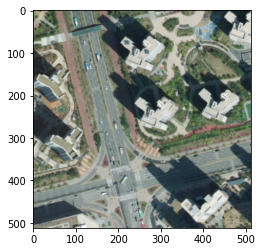

In [11]:
im1_path = os.path.join(rawtiffs_path, raw_tiffs[0])
im1 = tiff.imread(im1_path)

plt.figure()
plt.imshow(im1)

In [12]:
im1.shape

(512, 512, 3)

We can see that the image is an aerial image of a crossroad and has size 512*512 px with 3 color channels.

#### Multiple images

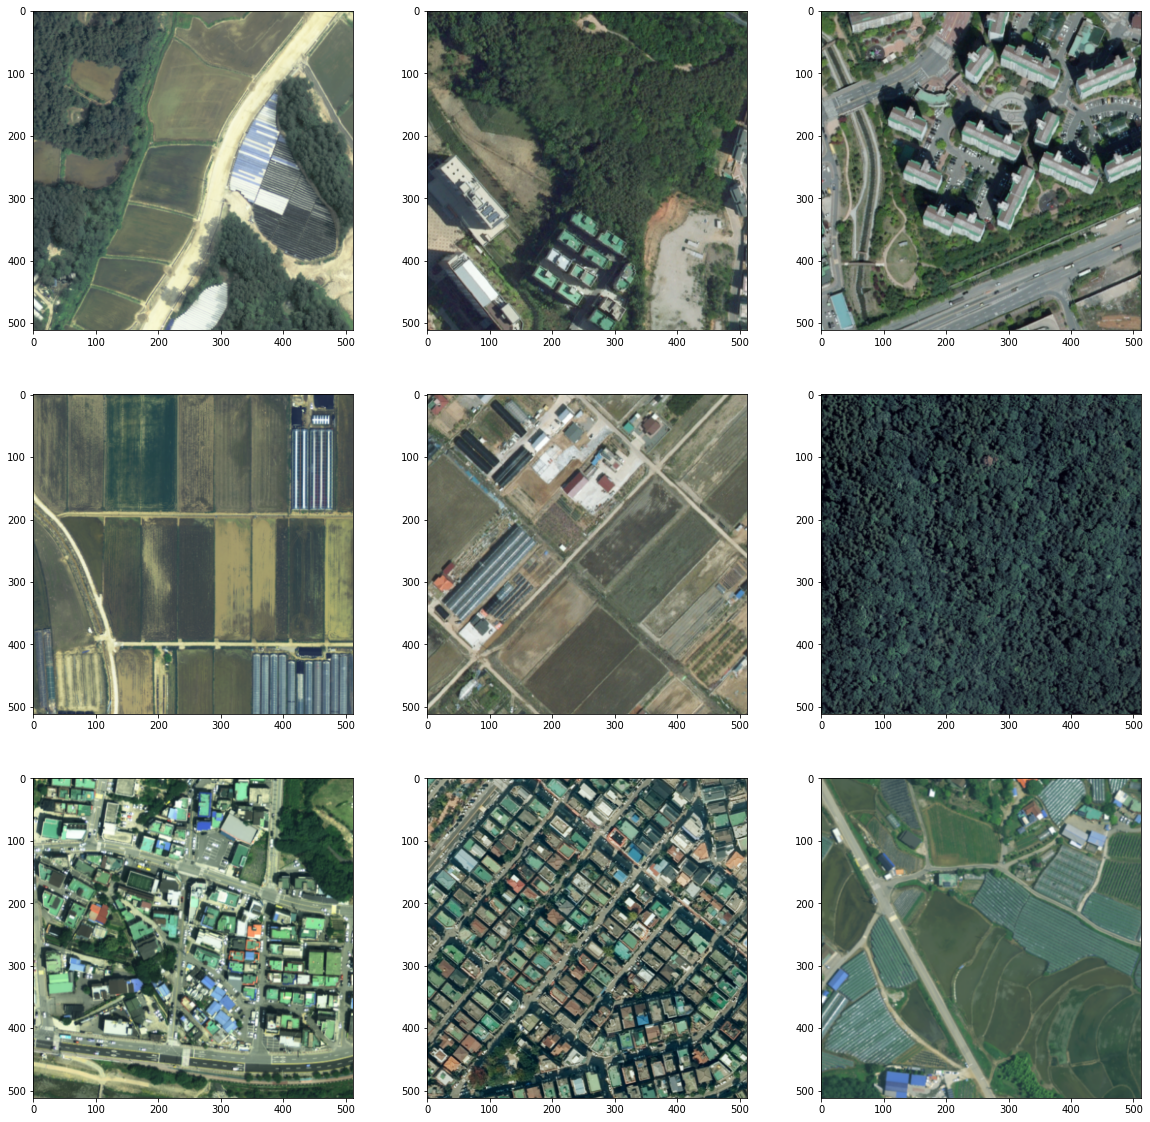

In [13]:
img_samples = random.sample(raw_tiffs, 9)

plt.figure(figsize=(20,20))
for i in range(9):
    plt.subplot(3,3,i+1)
    impath = os.path.join(rawtiffs_path, img_samples[i])
    im = tiff.imread(impath)
    plt.imshow(im)

#### Image Sizes

In [14]:
img_sizes = []

for imname in raw_tiffs:
    impath = os.path.join(rawtiffs_path, imname)
    im = tiff.imread(impath)
    img_sizes.append(im.shape)

In [15]:
set(img_sizes)

{(512, 512, 3)}

It seems that all image files have the same size: (512,512,3)

### Label files

We now move on and see what kind of information the label json files contain.

In [21]:
label1path = os.path.join(labeljsons_path, label_jsons[0])
label1 = json.load(open(label1path))

In [22]:
label1.keys()

dict_keys(['type', 'name', 'crs', 'features'])

Since we are making an image segmentation task, the important information isontained in 'features'.
Here is an example of the 1st feature.

In [23]:
feature1 = label1['features'][0]
feature1

{'type': 'Feature',
 'properties': {'ANN_CD': 10, 'ANN_NM': '건물'},
 'geometry': {'type': 'Polygon',
  'coordinates': [[[167095.6468231578, 560792.150136266],
    [167094.22999999954, 560792.150136266],
    [167094.22999999954, 560795.3082871719],
    [167095.02321734745, 560795.50801371],
    [167095.6468231578, 560792.150136266]]]}}

This tells us the type of object labelled in the picture:

In [24]:
feature1['properties']['ANN_NM']

'건물'

'건물' is korean for 'building'.

Instead, we can use 'ANN_CD', which stands for annotation code. 10 corresponds to 'buildings'.

The following tells us the polygon coordinates for the given feature (i.e. the building):

In [25]:
feature1['geometry']['coordinates']

[[[167095.6468231578, 560792.150136266],
  [167094.22999999954, 560792.150136266],
  [167094.22999999954, 560795.3082871719],
  [167095.02321734745, 560795.50801371],
  [167095.6468231578, 560792.150136266]]]

For images that are of size (512,512), these coordinates seem unreasonably large. We check the meta files for more information.

### META files

In [26]:
meta1_path = os.path.join(metafiles_path, meta_files[0])
meta1 = json.load(open(meta1_path))

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xb1 in position 269: invalid start byte

There seems to be invalid bytes in our files. We use *iconv* to fix this:
```
find -type f -exec iconv -f utf-8 -c {} -o $/path/to/output/directory/{} \;
```

In our actual project, we run the bash script *fix_utf.sh* to create fixed versions of the META files.

#### Example with 1 file

In [27]:
# New path containing the corrected meta files
metafiles_path = '/workspace/Competition/map_segmentation/data/RAW/train/meta_fixed'
meta_files = os.listdir(metafiles_path)
len(meta_files)

13520

In [28]:
meta1_path = os.path.join(metafiles_path, meta_files[0])
meta1 = json.load(open(meta1_path))

In [29]:
meta1

[{'img_id': 'LC_AP_37607046_068',
  'img_width': 512,
  'img_height': 512,
  'img_type': 'aerophoto',
  'img_coordinate': 'EPSG:5186',
  'coordinates': '168465.365000002, 559877.975136267',
  'img_resolution': 0.51,
  'img_time': 2018,
  'img_provided': '',
  'ann_id': 'LC_AP_37607046_068_FGT',
  'ann_type': 'polygon',
  'ann_file_type': 'tif',
  'provided_nm': 'ѱȸ'}]

Of the information provided in the meta files, 'img_coordinate' and 'coordinates' are the most important.

### Drawing polygons onto the images

As an example, we plot single features onto one image.

In [30]:
rawtiff_names[0]

'LC_AP_37607046_001'

In [31]:
# File names
f_id = rawtiff_names[0]
tiff_id = f_id+'.tif'
label_id = f_id + '_FGT.json'
meta_id = f_id + '_META.json'

# File paths
impath = os.path.join(rawtiffs_path, tiff_id)
labelpath = os.path.join(labeljsons_path, label_id)
metapath = os.path.join(metafiles_path, meta_id)

# Load image and files
im = tiff.imread(impath)
label_dict = json.load(open(labelpath))
meta_dict = json.load(open(metapath))

In [34]:
label_dict['features'][0] # Only show the first

{'type': 'Feature',
 'properties': {'ANN_CD': 10, 'ANN_NM': '건물'},
 'geometry': {'type': 'Polygon',
  'coordinates': [[[167095.6468231578, 560792.150136266],
    [167094.22999999954, 560792.150136266],
    [167094.22999999954, 560795.3082871719],
    [167095.02321734745, 560795.50801371],
    [167095.6468231578, 560792.150136266]]]}}

From the label_dict, we can see that the 10th(index = 9) feature corresponds to a road and the 3rd(index = 2) feature corresponds to a building.

Before plotting, we extract information from the META file:

In [35]:
meta_coord = meta_dict[0]['coordinates']
mc_split = meta_coord.split(', ')
org_x = float(mc_split[0])
org_y = float(mc_split[1])
img_res = meta_dict[0]['img_resolution']

**Example of a Road**

In [36]:
label_dict['features'][10]

{'type': 'Feature',
 'properties': {'ANN_CD': 30, 'ANN_NM': '도로'},
 'geometry': {'type': 'Polygon',
  'coordinates': [[[167355.3500000034, 560869.4767829783],
    [167311.39852617204, 560858.6598714562],
    [167268.53786615707, 560849.0424916383],
    [167263.41823240294, 560874.3272134445],
    [167266.74986363348, 560875.0146929026],
    [167315.97787617304, 560886.7901643435],
    [167355.3500000034, 560896.7748216459],
    [167355.3500000034, 560869.4767829783]]]}}

In [37]:
feature = label_dict['features'][10]
coords = feature['geometry']['coordinates'][0]

transformed_coords = []
for point in coords:
    tpoint = (max(0,point[0]-org_x), max(0,org_y-point[1]))
    transformed_coords.append(tpoint)
xs = [x[0]*(1/img_res) for x in transformed_coords]
ys = [x[1]*(1/img_res) for x in transformed_coords]

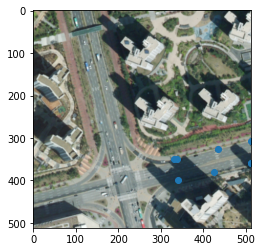

In [38]:
plt.figure()
plt.imshow(im)
plt.scatter(xs,ys)

We can see that this particular feature corresponds to the road on the right.

**Example of a Building**

In [39]:
label_dict['features'][2]

{'type': 'Feature',
 'properties': {'ANN_CD': 10, 'ANN_NM': '건물'},
 'geometry': {'type': 'Polygon',
  'coordinates': [[[167322.8489230154, 560836.7208120805],
    [167329.3022064185, 560828.9605345783],
    [167298.3427835132, 560798.4095473225],
    [167289.84732181768, 560799.6348542981],
    [167277.43096556852, 560813.4547986492],
    [167271.75339560368, 560818.6519574972],
    [167272.0508035167, 560821.4628401108],
    [167278.57449764758, 560827.4901662095],
    [167285.35452957882, 560826.1014849667],
    [167291.56275157974, 560819.4031401725],
    [167291.8078129775, 560816.7074648172],
    [167294.5851754565, 560814.0934766122],
    [167296.46397948152, 560815.8089063744],
    [167294.91192398462, 560817.5243361408],
    [167301.2018331159, 560823.4058096203],
    [167302.2637658284, 560822.425564036],
    [167302.75388862166, 560823.0790611011],
    [167298.83290630204, 560827.0000434185],
    [167304.79606691631, 560832.9632040261],
    [167308.71704923152, 560829.1239088

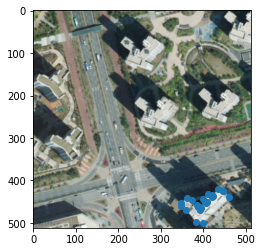

In [40]:
feature = label_dict['features'][2]
coords = feature['geometry']['coordinates'][0]

transformed_coords = []
for point in coords:
    tpoint = (max(0,point[0]-org_x), max(0,org_y-point[1]))
    transformed_coords.append(tpoint)
xs = [x[0]*(1/img_res) for x in transformed_coords]
ys = [x[1]*(1/img_res) for x in transformed_coords]

plt.figure()
plt.imshow(im)
plt.scatter(xs,ys)

Because there was no explanation of the information contained within the json files, it took a lot of trial and error to figure out how to properly draw the polygons onto the image. 
* 'coordinates' of a feature in the label files are polygon coordinates for the given feature.
    * The corodinates are stored as a list of lists. 
    * Each inner list has a length of 2, with the first element corresponding to the x-coordinate and the second element corresponding to the y-coordinate. 
* HOWEVER, these coordinates have to be transformed before plotting on to the image.
* 'coordinates' in the META files refer to the coordinates of the origin of the corresponding 'tiff' file.
* To properly plot the polygon coordinates of a given feature, the coordinate value of the origin must be subtracted from the polygon of the coordinate.
* Furthermore, to properly scale the coordinates of the polygons, the difference in coordinate values must be divided by the 'img_resolution' provided in the META file.

## Process the raw data

We now process the raw data in order to make the dataset used for our image segmentation competition. We begin by making image masks.

### Making image masks
Having looked through many examples within the dataset, we concluded that the labelling quality of the 'building' features were best. Therefore, we decided to make the task be determining whether or not each pixel of the image corresponds to a building.

We first extract only the images that contain buildings:

In [41]:
contains_buildings = []
for lbl in label_jsons:
    # load label json file
    lbl_path = os.path.join(labeljsons_path,lbl)
    label = json.load(open(lbl_path))
    # loop through featrues
    for feat in label['features']:
        if feat['properties']['ANN_CD']==10:
            img_name = lbl.split('_FGT.json')[0]
            contains_buildings.append(img_name)
            break

len(contains_buildings)

10533

We see that 10533 of the total 13520 images contain buildings. We use only these images.

#### Example Image mask

In [42]:
# Function to transform polygon coordinates
def coord_to_points(coords, org_x, org_y, resolution):
    new_coord = []
    for point in coords:
        npoint = (max(0,point[0]-org_x), max(0,org_y-point[1]))
        new_coord.append(npoint)
    xs = [int(np.round(x[0]/resolution)) for x in new_coord]
    ys = [int(np.round(x[1]/resolution)) for x in new_coord]
    return xs,ys

In [45]:
rawtiffs_path = '/workspace/Competition/map_segmentation/data/RAW/train/raw_tiffs'
labeljsons_path = '/workspace/Competition/map_segmentation/data/RAW/train/label_json'
metafiles_path = '/workspace/Competition/map_segmentation/data/RAW/train/meta_fixed'

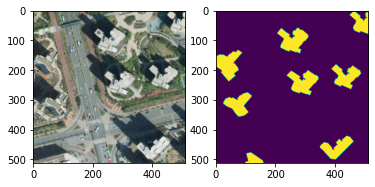

In [46]:
# File names
fid = contains_buildings[0]
imfile = fid+'.tif'
metafile = fid + '_META.json'
labelfile = fid + '_FGT.json'

# File paths
impath = os.path.join(rawtiffs_path, imfile)
metapath = os.path.join(metafiles_path, metafile)
labelpath = os.path.join(labeljsons_path, labelfile)

# Load files
im = tiff.imread(impath)
label_dict = json.load(open(labelpath))
meta_dict = json.load(open(metapath))

# Load coordinates for buildings
building_coordinates = []
for feat in label_dict['features']:
    if feat['properties']['ANN_CD']==10:
        coords = feat['geometry']['coordinates'][0]
        building_coordinates.append(coords)

# Load META info
meta_coord = meta_dict[0]['coordinates']
mc_split = meta_coord.split(', ')
org_x = float(mc_split[0])
org_y = float(mc_split[1])
img_res = meta_dict[0]['img_resolution']

# Make and combine masks
allmasks = []
for sub_coord in building_coordinates:
    xs,ys = coord_to_points(sub_coord, org_x, org_y, img_res)
    points = np.array(list(zip(xs,ys)))
    maskim = np.zeros((512,512),dtype=np.int32)
    maskim = cv2.fillPoly(maskim, pts=[points], color=(255,255,255))
    allmasks.append(maskim)
fin_mask = np.zeros((512,512), dtype=np.int32)
for submask in allmasks:
    fin_mask = fin_mask + submask

plt.figure()
plt.subplot(1,2,1)
plt.imshow(im)
plt.subplot(1,2,2)
plt.imshow(fin_mask)


We have succesfully made a mask for this first image. 
The following script is used to make masks for all images containing buildings. It also converts all the '.tif' images.
```
make_masks.py
```

The script takes 2 arguments:
* *input_dir*: Path to directory containing the 'raw_tiffs', 'label_json', and 'meta_fixed' folders.
* *output_dir*: Path to directory that will contain the processed images.

## Splitting the data into train and test

Having run the scripts above, we first check to see if the names of the images match the names of the masks:

In [47]:
images_path =  '/workspace/Competition/map_segmentation/data/processed/input_images'
masks_path = '/workspace/Competition/map_segmentation/data/processed/masks'

images = os.listdir(images_path)
masks = os.listdir(masks_path)

images.sort()
masks.sort()

images==masks

True

Process of splitting the data:
* Randomly select 20% of the data to use as test data.
* Encode file name to prevent any information to remain in file names.
* Save original file name and encoded file name as csv.
* Save a data frame with the train image and mask names.

This is done with the script *split_data.py*. It takes two arguments:
* *input_dir*: Path to directory containing the folders of the raw image files and the mask files.
* *output_dir*: Path to directory that will contain the train and test datasets, along with the key.

## Summary
In this notebook, we processed the raw data and made data files suitable for a competition:
* EDA of raw files (tiff images, json label files, json meta data files).
* Convert tiff images to png images.
* Create mask image files in png format.
* Split data into train and test data, and make key files in csv format.

There are a few more things to do:
* Train a baseline model that participants can use / refer to. The baseline model can be found [here](https://github.com/parksu111/map-segmentation/blob/main/baseline.ipynb).
* Prepare files for evaluation of submissions. The details of this step can be found in this [notebook](https://github.com/parksu111/map-segmentation/blob/main/evaluation_prep.ipynb).